In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

Analyze first 20 lines so the last secular equation data saved corresponds to the instanton.

In [2]:
# compile everything with this run:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData,20);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

20-element Array{Float64,1}:
   0.263788
   5.93862 
   9.01311 
  11.1542  
  12.614   
  13.269   
  16.929   
  17.1091  
  17.176   
  20.7503  
  22.5123  
  23.8694  
  23.8756  
  23.8889  
  23.9756  
  24.2955  
  28.9111  
  32.2817  
  67.5671  
 154.07    

9.341606 seconds (2.81 M allocations: 153.328 MB, 0.39% gc time)


In [3]:
outputData.score[end] # minimum score means saved data is instanton data

0.26378783883291707

In [5]:
using JLD
sec = load("secular.jld")
c,poles,num = (sec["c"],sec["poles"],sec["num"])

(0.00410091870624481,[815719.9899566219,305811.3229721698,114654.1213784132,42985.0966795088,16115.6631625296,6041.9772953793],[8.998760475778909,29.909619606707565,33.2539362972484,29.509208744939315,23.669752732223515,17.922670615137122])

In [9]:
s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]
s(v::Float64) = sumabs2(num./(v - poles))
w(vv::Vector{Float64}) = [float(num./(v - poles)) for v in vv]
w(v::Float64) = float(num./(v - poles))

w (generic function with 2 methods)

In [10]:
using PyPlot
PyPlot.svg(true)

true

In [12]:
sort(poles)

6-element Array{Float64,1}:
   6041.98     
  16115.7      
  42985.1      
      1.14654e5
      3.05811e5
 815720.0      

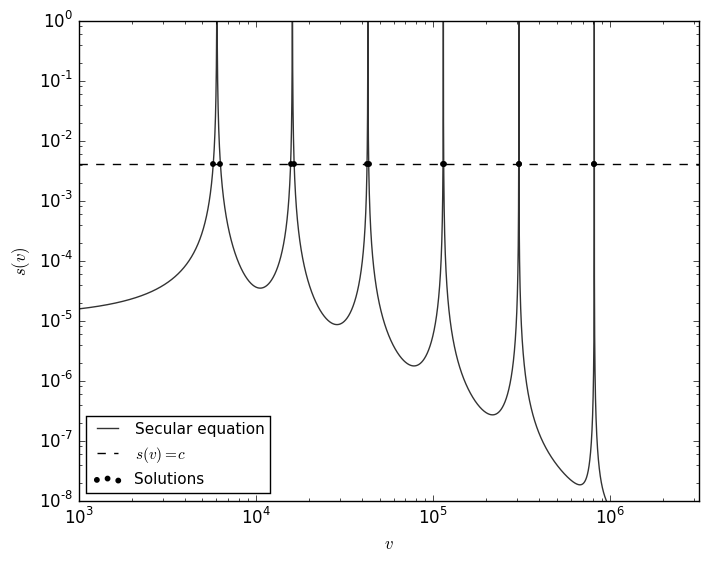

In [57]:
vv = collect(linspace(10^(3),10^(6.5),1000000));
sols = solvesecular(num,poles,c)[1]
plot(vv,s(vv),"black",alpha=0.8)
xscale("log")
yscale("log")
hold(true)
plot([vv[1];vv[end]],[c;c],"k--")
scatter(sols,s(sols),c="black",s=10)
axis([vv[1];vv[end];1e-8;1])
xlabel(L"v")
ylabel(L"s(v)")
legend(["Secular equation";L"s(v)=c";"Solutions"],fontsize=11,loc=3)

savefig("../paper2/images/secular.pdf")

In [34]:
function solvesecular(
    num::Vector{Float64},
    poles::Vector{Float64},
    c::Float64
    )
    s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]
    s(v::Float64) = sumabs2(num./(v - poles))
    w(vv::Vector{Float64}) = [float(num./(v - poles)) for v in vv]
    w(v::Float64) = float(num./(v - poles))
    tiny = c/1e8

    vals = Vector{Float64}()
    sortedpoles = sort(poles)

    for i in 1:length(sortedpoles)
        upper = sortedpoles[i]

        # head left
        dist = finddist(i,sortedpoles,true)
        lower = upper - dist/2
        intersect = secularintersect(c,upper,lower,s,tiny)

        isinf(intersect) && continue

        # there must be at least one solution for leftmost pole
        if i == 1
            ex = 0
            while isnan(intersect)
                ex += 1
                if ex == 10
                    intersect = NaN
                    break
                end
                warn("expanding $ex")
                lower -= 100*dist
                intersect = secularintersect(c,upper,lower,s,tiny)
            end
        end
        push!(vals,intersect)

        # head right
        dist = finddist(i,sortedpoles,false)
        lower = upper + dist/2
        intersect = secularintersect(c,upper,lower,s,tiny)
        # there must be at least one solution for rightmost pole
        if i == length(sortedpoles)
            ex = 0
            while isnan(intersect)
                ex += 1
                if ex == 10
                    intersect = NaN
                    break
                end
                warn("expanding $ex")
                lower += 100*dist
                intersect = secularintersect(c,upper,lower,s,tiny)
            end
        end
        push!(vals,intersect)
    end
    filter!(x -> !isnan(x),vals)
    return vals, w(vals)
end

""" Given current pole index, vector of sorted poles, and desired search direction (`left` or right==`!left`), return appropriate initial search distance for `secularintersect`.
"""
function finddist(
    i::Int64,
    sortedpoles::Vector{Float64},
    left::Bool
    )
    p = sortedpoles[i]
    if length(sortedpoles) == 1
        dist = p
    elseif i == 1 && left
        dist = abs(p - sortedpoles[2])
    elseif i == length(sortedpoles) && !left
        dist = abs(p - sortedpoles[end-1])
    else
        dist = left ? abs(p - sortedpoles[i-1]) : abs(p - sortedpoles[i+1])
    end
    return dist
end

""" Given c, upper bound, lower bound, function s, and a "tiny" number, return the value v where s(v) = c (if it exists).
"""
function secularintersect(
    c::Float64,
    upper::Float64,
    lower::Float64,
    s::Function,
    tiny::Float64
    )
    if c == 0.0
        error("c > 0 required; s(v) = 0 has no solution")
    end
    if s(lower) > 1.0/tiny
        warn("c is too small; s(v) = c has no reasonable solution")
        return Inf
    end
    ubound = upper
    olddiff = 0.0
    v = mean([upper;lower])
    currentdiff = s(v) - c

    while abs(currentdiff) > tiny
        if abs(currentdiff - olddiff) < tiny
            #||            (currentdiff > 0 && olddiff > 0 &&  currentdiff > olddiff)
            return NaN
        end
        if currentdiff > 0
            upper = v
        else
            lower = v
        end
        v = mean([upper;lower])
        olddiff = currentdiff
        currentdiff = s(v) - c
    end
    return v
end

secularintersect (generic function with 1 method)